# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Are there any inherent or cross contact allergens or intolerants?' , based on the Input Data

In [1]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

C:\Users\103467\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## File name and other important parameters like ngram_range set

In [2]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "D:/Pepsico/FSHA - RPA.xlsm"
#n_components = 0

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) - Q1

In [3]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [4]:
fsha_data = pd.read_excel(filename)

In [5]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,targetMarket,fastTrack,baseProduct,prodModifications,newIngredient,approvedPackage,potentialMicrobial,crossContactAllergens,chokeHazard,operationalAllergen
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,"People with allergies to milk, lactose, peanuts.",Fast Track is NOT allowed for this project.,No,No,Yes,No,No,Yes,No,Yes
1,36559-FSHA-in process (Phase 1 Indian pellet l...,Simba Shapes Next Gen,36559,"Simba Shapes - Playz, Simba Shapes Twistz",Breakthrough - South Africa & Nigeria,Purchase an existing Pellet spec used by Pepsi...,unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,"Suitable for consumers, potential choking haza...",Fast Track is NOT allowed for this project.,Yes,Yes,Yes,No,No,Yes,Yes,Yes
2,36559-FSHA-in process (Phase 2 Next Gen Launch...,Simba Shapes Next Gen,36559,Simba Shapes - Playz,Breakthrough - South Africa & Nigeria,"Commission a new pellet line in Prospecton, So...",unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,"Suitable for consumers, potential choking haza...",Fast Track is NOT allowed for this project.,Yes,Yes,Yes,No,No,Yes,Yes,Yes
3,36559-FSHA-in process (Phase 2 Next Gen Launch...,Simba Shapes Next Gen,36559,Simba Shapes Twistz,Breakthrough - South Africa & Nigeria,"Commission a new pellet line in Prospecton, So...",unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,Beaumont Park / Johannesburg,...,"Suitable for consumers, potential choking haza...",Fast Track is NOT allowed for this project.,Yes,Yes,Yes,No,No,Yes,Yes,Yes
4,Accolade Blend Flex project FSHA 5.4.1 + FS in...,Oil BlendFlex - HOSO,#44720,Lays and Simba Ruffles,Business continuation &/or Productivity,Validate a new oil blend for Lays and Simba to...,Lays and Simba Ruffles,Lizel Laubscher,ESSA,SSA,...,"Yes, no change to current product",Fast Track is allowed for this project.,No,No,No,No,No,Yes,No,Yes


In [6]:
fsha_data.columns

Index(['File Name', ' projName', 'accolNumber', 'PDA_projName', 'projType',
       'projDesc', 'formulaNumber', 'owner', 'sector', 'center',
       'Current TSG Stage', 'FSAssessors', 'FSDate', 'WHTD', 'manufacSite',
       'PlantTrial', 'packMaterial', 'CPD-ProdName', 'CPD-ProdName-Desc',
       'procPlat', 'intrinsicProd', 'preservatives', 'pH', 'waterActivity',
       'packaging', 'otherFSA', 'allergens', 'prodStorageDist', 'shelfLife',
       'TCG', 'foodSafetyProdClaims', 'cookedOrHeated', 'specificStorage',
       'labelingInstructions ', 'mishandled', 'targetMarket', 'fastTrack',
       'baseProduct', 'prodModifications', 'newIngredient', 'approvedPackage',
       'potentialMicrobial', 'crossContactAllergens', 'chokeHazard',
       'operationalAllergen'],
      dtype='object')

In [7]:
#Check few categorical values
fsha_data[['cookedOrHeated', 'specificStorage']]

,cookedOrHeated,specificStorage
0,No,No
1,No,Ambient Storage
2,No,Ambient Storage
3,No,Ambient Storage
4,No,"Yes, do not store after opening"
5,no,no
6,"NO, RTE",N/A ambient
7,na,na
8,No,No
9,no,no


In [8]:
fsha_data['combined'] = fsha_data['cookedOrHeated'] + fsha_data['specificStorage']

In [9]:
fsha_data['combined']

0                                            NoNo
1                              No Ambient Storage
2                              No Ambient Storage
3                              No Ambient Storage
4               NoYes, do not store after opening
5                                            nono
6                              NO, RTEN/A ambient
7                                            nana
8                                            NoNo
9                                            nono
10                                           nono
11    Ready to eat snackDo not store open product
12                                           nono
Name: combined, dtype: object

# Based on Analysis select the Features (X)

In [11]:
#selecting set of columns as Features
features_df=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','cookedOrHeated', 'specificStorage']]


# Standardize Categorical Columns (those columns which have values in a fixed set, ex: packaging) - Q 1

In [12]:
#ph value label
features_df['PH_label']=features_df['pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else str(0))
def ph_process(x):
    if(len(x)>0):
        x = str(x[0])
    else:
        x = str(x)
    return x
features_df['PH_label']=features_df['PH_label'].apply(lambda x:ph_process(x))    
    
#'specificStorage'column label
print("specificStorage from extract")
def specificStorage(x):
    x=str(x.lower())
    print(x)
    if x.__contains__('do not store'):
        return 'do not store open product'
    elif x.__contains__('ambient')  :
        return 'ambient storage'
    elif x.__contains__('no')  :
        return 'no'
    else:
        return 'NA'
features_df['specificStorage_label']=features_df['specificStorage'].apply(lambda x:specificStorage(x))   
print("specificStorage after transformation")
print(features_df['specificStorage_label'])

#'cookedorHeated'column label
def cookedOrHeated(x):
    x=str(x.lower())
    #print(x)
    if x.__contains__('no'):
        return 'no'
    elif x.__contains__('ready to eat')  :
        return 'no'
    else:
        return 'NA'
features_df['cookedOrHeated_label']=features_df['cookedOrHeated'].apply(lambda x:cookedOrHeated(x))    
#print(features_df['cookedOrHeated_label'])

#'prod_storageDist'column label
print("prod_storageDist from extract")
def prod_storageDist(x):
    
    x=str(x.lower())
    print(x)
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
features_df['prod_storageDist_label']=features_df['prodStorageDist'].apply(lambda x:prod_storageDist(x))      
print("prod_storageDist after transformation")
print(features_df['prod_storageDist_label'])

#water activity
def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
features_df['waterActivity_label']=features_df['waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'
print("packaging from extract")
def packaging(x):
    x=str(x)
    x=x.lower()
    print(x)
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
    
features_df['packaging_label']=features_df['packaging'].apply(lambda x: packaging(x))  
print("packaging after data transformation")
print(features_df['packaging_label'])
  
#'preservatives'
def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
features_df['preservatives_label']=features_df['preservatives'].apply(lambda x:preservatives(x))

#' otherFSA'
def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
features_df['otherFSA_label']=features_df['otherFSA'].apply(lambda x:otherFSA(x))


def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a',x)):
        return 'NA'
    else:
        return(x)

features_df['foodSafety_prodClaims_label']=features_df['foodSafetyProdClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'
def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
features_df['targetMarket_label']=features_df['targetMarket'].apply(lambda x:targetMarket(x))



specificStorage from extract
no
ambient storage
ambient storage
ambient storage
yes, do not store after opening
no
n/a ambient
na
no
no
no
do not store open product
no
specificStorage after transformation
0                            no
1               ambient storage
2               ambient storage
3               ambient storage
4     do not store open product
5                            no
6               ambient storage
7                            NA
8                            no
9                            no
10                           no
11    do not store open product
12                           no
Name: specificStorage_label, dtype: object
prod_storageDist from extract
store in a dry, cool and away from sun place.
ambient 
ambient 
ambient 
rte
ambient
ambient, rte
silo
store in a dry, cool and away from sun place.
ambient
ambient
store in a cool dry place at ambient temperature
none
prod_storageDist after transformation
0     Keep away from sun
1                ambient

# Drop the raw columns and retain transformed columns

In [13]:
features_df=features_df.drop(['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA','prodStorageDist','foodSafetyProdClaims','targetMarket','cookedOrHeated', 'specificStorage'],axis=1)


In [14]:
train_df = features_df

In [15]:
train_df

,allergens,newIngredient,PH_label,specificStorage_label,cookedOrHeated_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes,0,no,no,Keep away from sun,low,atmosphere,NA,NA,Claims Made,Allergy
1,Inherent:\nCheddar Playz: Cereals containing G...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",nitrogen,NA,Moisture,NA,Choking hazard for children
2,Pellets Inherent:\nCereals containing Gluten -...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",no nitrogen,NA,Moisture,NA,Choking hazard for children
3,Pellets Inherent:\nCereals containing Gluten -...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",no nitrogen,NA,Moisture,NA,Choking hazard for children
4,Standard allergen management for Seasoning. Th...,No,0,do not store open product,no,RTE,low,nitrogen,NA,NA,NA,no
5,Inherent\n\nParmesan Cheese & Roasted Garlic B...,Yes,0,no,no,ambient,low,nitrogen,Not used as preservatives,NA,50% less fat comparing to fried potato chips,no
6,"Inherent - Wheat, Gluten, Sulphites, Soya, Mil...",Yes,0,ambient storage,no,ambient,low,packaging conditions tbc,Used in seasoning,NA,nan,Allergy
7,All current suppliers to PepsiCo have cross co...,No,0,NA,NA,NA,0.2,na,NA,NA,na,same as current
8,"One of below seasonings will be chosen, allerg...",No,0,no,no,Keep away from sun,low,atmosphere,NA,NA,No Claims Made,Allergy
9,Base allergens: None\nTop seasoning: Milk\n\nC...,Yes,0,no,no,ambient,low,NA,Not used as preservatives,NA,no preservatives,no


# Define reusable code to Vectorize Text column (ex: Allergens) using TF-IDF Vectorizer, after doing Text data normalization

In [16]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)

    x_train = x_train.astype('float32')
    return x_train

# Define method to perform Text standardization (categorical data, text data). This method peforms a number of steps. It Label encodes the transformed categorical features, standardizes and vectorizes Text features(allergens), performs Feature Scaling and Dimensionality Reduction (PCA), and finally concatenates the columns to create the Feature Matrix (X) - Q 1

In [17]:
whiten = False
random_state = 42
svd_solver="full"
def preprocess_text(train_df,y,n_comp,n_gram_range):

    train_df['preservatives_label'] = train_df['preservatives_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['waterActivity_label'] = train_df['waterActivity_label'].astype('category').cat.codes
    train_df['packaging_label'] = train_df['packaging_label'].astype('category').cat.codes
    train_df['otherFSA_label'] = train_df['otherFSA_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['foodSafety_prodClaims_label'] = train_df['foodSafety_prodClaims_label'].astype('category').cat.codes
    train_df['targetMarket_label'] = train_df['targetMarket_label'].astype('category').cat.codes
    train_df['newIngredient'] = train_df['newIngredient'].astype('category').cat.codes
    
    train_df['cookedOrHeated_label'] = train_df['cookedOrHeated_label'].astype('category').cat.codes
    print("specitifStorage_label before Label encoding")
    print(train_df['specificStorage_label'])
    train_df['specificStorage_label'] = train_df['specificStorage_label'].astype('category').cat.codes
    print("specitifStorage_label after Label encoding")
    print(train_df['specificStorage_label'])
    print("Allergens before encoding")
    print(train_df['allergens'][0])
    norm_allergens = normalize_corpus(train_df['allergens'])
    print("Allergens after nomalization")
    print(norm_allergens[0])
    train_df = train_df.drop(['allergens'],axis=1)
    
    #Apply scaling on the data
    x_train = StandardScaler().fit_transform(train_df)
    print(x_train.shape)
    train_labels = y
    
    #Vectorize the text data
    x_ngram = ngram_vectorize(norm_allergens, train_labels,n_gram_range)
    x_ngram=x_ngram.toarray()
    print(x_ngram.shape)
    
    #Apply PCA based on trial run
    if (n_comp > 0):
        pca = PCA(n_components=n_comp,svd_solver=svd_solver,whiten=whiten, random_state=42)
        x_pca = pca.fit_transform(x_ngram)
        x_train = np.concatenate((x_train,x_pca),axis=1)
    else:
        x_train = np.concatenate((x_train,x_ngram),axis=1)
    print(x_train.shape)
    return x_train

# Transform Target (potentialMicrobial) into binary value (1=Yes, 0=No)

In [18]:
train_y=[]
for i in range (len(fsha_data)):
    if fsha_data["potentialMicrobial"][i] =='Yes':
        train_y.append(1)
    else:
        train_y.append(0)

In [19]:
y = train_y

# Pre-process the data and check the values before and after transformation

In [20]:
n_components=0
x_train = preprocess_text(train_df,y,n_components,ngram_range_inp)
x_train.shape

specitifStorage_label before Label encoding
0                            no
1               ambient storage
2               ambient storage
3               ambient storage
4     do not store open product
5                            no
6               ambient storage
7                            NA
8                            no
9                            no
10                           no
11    do not store open product
12                           no
Name: specificStorage_label, dtype: object
specitifStorage_label after Label encoding
0     3
1     1
2     1
3     1
4     2
5     3
6     1
7     0
8     3
9     3
10    3
11    2
12    3
Name: specificStorage_label, dtype: int8
Allergens before encoding
Allergens in seasonings:
CQ69 Vegetable Blend, McCormick - milk, lactose
2763030 Cheese, Symrise - milk, lactose

The product may contain peanut.
Existing allergens in manufacturing plant: celery, cereals containing gluten (wheat, barley, oats), milk, mustard, peanuts, soya.
Existin

(13, 106)

# Check a row of X matrix (corresponding to one FSHA Form), how it looks after vectorization

In [215]:
x_train[0]

array([ 0.79056942, -0.28867513,  0.96362411,  0.28867513, -1.84626533,
       -0.27091418, -0.86803708, -0.61357199,  0.54772256, -1.08388746,
       -1.43676223,  0.25602064,  0.1068191 ,  0.        ,  0.1068191 ,
        0.1068191 ,  0.15534812,  0.        ,  0.        ,  0.        ,
        0.18944563,  0.2136382 ,  0.15534812,  0.15534812,  0.1068191 ,
        0.        ,  0.        ,  0.        ,  0.09472281,  0.15534812,
        0.15534812,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.2136382 ,  0.2136382 ,  0.        ,  0.        ,
        0.        ,  0.10437527,  0.        ,  0.        ,  0.15534812,
        0.        ,  0.        ,  0.        ,  0.        ,  0.17068042,
        0.        ,  0.07767406,  0.1068191 ,  0.        ,  0.        ,
        0.1068191 ,  0.1068191 ,  0.09472281,  0.09472281,  0.1068191 ,
        0.1068191 ,  0.24250124,  0.17068042,  0.2136382 ,  0.        ,
        0.18944563,  0.2136382 ,  0.        ,  0.        ,  0.  

# Check target - y (potentialMicrobial) after binarization

In [216]:
y

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

# Define method to evaluate Machine Learning models with the X and y vectors created above, and check the effectiveness of each. Also store the results in array to be plotted in graph for visualization

In [217]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)

    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        for i in range (len(pred)):
            if (pred[i]>=0.3):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=0.3):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train)
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

In [218]:
X, y = x_train,y

In [219]:
K = pd.DataFrame(X)

In [220]:
K.shape

(13, 106)

# Check the final X matrix (Vectorized form of the Text Inputs) - Q 2

In [221]:
K.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.790569,-0.288675,0.963624,0.288675,-1.846265,-0.270914,-0.868037,-0.613572,0.547723,-1.083887,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.112390,0.189446,0.0,0.000000
1,0.790569,-0.288675,-0.963624,0.288675,0.725319,1.490028,0.385794,-0.613572,-1.825742,-0.520266,...,0.341073,0.094643,0.0,0.213458,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,0.790569,-0.288675,-0.963624,0.288675,0.725319,1.490028,1.012710,-0.613572,-1.825742,-0.520266,...,0.132855,0.147462,0.0,0.000000,0.0,0.0,0.087483,0.000000,0.0,0.166293
3,0.790569,-0.288675,-0.963624,0.288675,0.725319,1.490028,1.012710,-0.613572,-1.825742,-0.520266,...,0.132855,0.147462,0.0,0.000000,0.0,0.0,0.087483,0.000000,0.0,0.166293
4,-1.264911,-0.288675,0.000000,0.288675,-0.131876,-0.270914,0.385794,-0.613572,0.547723,-0.520266,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000


# Define method to create samples by using signal.resample from scipy package - Q1

In [105]:
def generate_samples(sampleSize):
    for i in range(len(list(K))):
        x = K.iloc[:,i].astype(int)
        if i == 0:
            f = pd.Series(signal.resample(x, sampleSize))
        else:
            f = pd.concat([f, pd.Series(signal.resample(x,sampleSize))],axis=1)
    f.columns = list(X)

    y=[]
    for i in range(0,sampleSize):
        y.append(random.choices([0,1]))
        
    return f,y


# Invoke method defined above to generate samples with sample Size as parameter (ex: 100,500,1000,2000)

In [246]:
X,y = generate_samples(2000)
X.shape

(2000, 106)

# Split the X and y into Train and Test data with a ratio of 0.2 (ie Test Data = 0.2 of Full data set)

In [247]:
selector = SelectKBest(f_classif, k='all')

y = np.array(y)

#X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

#print(y_test)

(1600, 106)
(400, 106)


# Evaluate Machine Learning Models from a List (using the reusable method defined above). Store the results (Accuracy score - train, accuracy score - test, and training time) in a List for data visualization

In [248]:
# Not using MultinomialNaiveBayes, because sampled data has negative components. NaiveBayes expects frequencies in the positive

results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")


________________________________________________________________________________
Training: 
1600
model name:Pipeline
train time: 986999.000s
f1_score:   0.368
f1_score_train:   0.366
classification report:
             precision    recall  f1-score   support

          0       0.53      0.76      0.62       206
          1       0.52      0.28      0.37       194

avg / total       0.53      0.53      0.50       400

confusion matrix:
[[156  50]
 [139  55]]
Ridge Classifier
________________________________________________________________________________
Training: 
1600
model name:RidgeClassifier
train time: 992999.000s
f1_score:   0.368
f1_score_train:   0.366
classification report:
             precision    recall  f1-score   support

          0       0.53      0.76      0.62       206
          1       0.52      0.28      0.37       194

avg / total       0.53      0.53      0.50       400

confusion matrix:
[[156  50]
 [139  55]]
dimensionality: 106
density: 0.103774
______________

# Define Neural Network model

In [249]:
def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Compile Model

In [250]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=2
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_40 (Dropout)         (None, 106)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                6848      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


# Train model and store results in array

In [251]:
print('=' * 80)
print("Keras Dense Neural Network")
results.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
1600
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x000000002C80DAC8>
Train on 1600 samples, validate on 400 samples
Epoch 1/100
 - 0s - loss: 0.6981 - acc: 0.5050 - val_loss: 0.6883 - val_acc: 0.5450
Epoch 2/100
 - 0s - loss: 0.6960 - acc: 0.5188 - val_loss: 0.6895 - val_acc: 0.5275
Epoch 3/100
 - 0s - loss: 0.6978 - acc: 0.5013 - val_loss: 0.6904 - val_acc: 0.5250
Epoch 4/100
 - 0s - loss: 0.6957 - acc: 0.5100 - val_loss: 0.6910 - val_acc: 0.5225
train time: 804669.000s
f1_score:   0.653
f1_score_train:   0.654
classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       206
          1       0.48      1.00      0.65       194

avg / total       0.24      0.48      0.32       400

confusion matrix:
[[  0 206]
 [  0 194]]


# Visualize the results from multiple Machine Learning Models (accuracy - train, accuracy - test, training time)

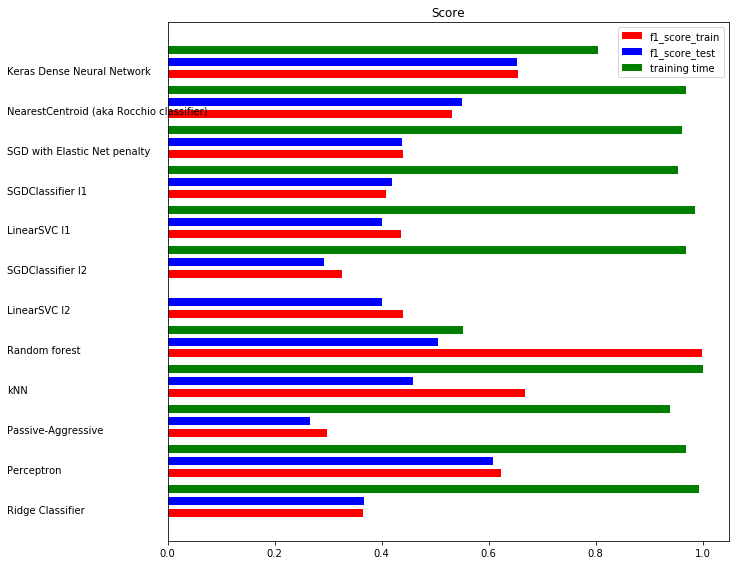

In [252]:
# make some plots
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results

training_time = np.array(training_time) / np.max(training_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

# Store the best model and accuracy for a sample Size in array

In [229]:
#Sample Size 100
index100=np.argmax(f1_score_test)
print(index100)
f1score100 = f1_score_test[index100]
print(f1score100)
print(model_name[index100])

11
0.6206896551724138
Keras Dense Neural Network


In [237]:
#Sample Size 500
index500=np.argmax(f1_score_test)
f1score500 = f1_score_test[index500]
print(f1score500)
print(model_name[index500])

0.6394557823129251
Keras Dense Neural Network


In [245]:
#Sample Size 1000
index1000=np.argmax(f1_score_test)
f1score1000 = f1_score_test[index1000]
print(f1score1000)
print(model_name[index1000])

0.6440677966101694
Keras Dense Neural Network


In [253]:
#Sample Size 2000
index2000=np.argmax(f1_score_test)
f1score2000 = f1_score_test[index2000]
print(f1score2000)
print(model_name[index2000])

0.6531986531986532
Keras Dense Neural Network


# Plot the accuracy scores (F1-scores) of the best model vs sample Size

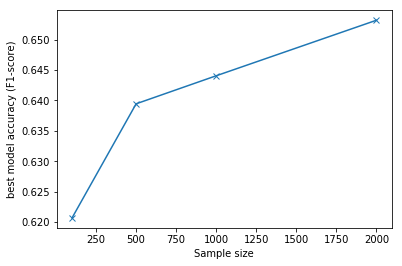

In [254]:
##Plotting the best model f1-scores

import matplotlib.pyplot as plt
plt.plot([100, 500, 1000, 2000],[f1score100,f1score500,f1score1000,f1score2000],marker="x")
plt.ylabel('best model accuracy (F1-score)')
plt.xlabel('Sample size')
plt.show()

# Print the best Model names at various sample Sizes

In [255]:
print("Best classifier is:"+model_name[index100],"||f1_score",f1score100)
print("Best classifier is:"+model_name[index500],"||f1_score",f1score500)
print("Best classifier is:"+model_name[index1000],"||f1_score",f1score1000)
print("Best classifier is:"+model_name[index2000],"||f1_score",f1score2000)

Best classifier is:Keras Dense Neural Network ||f1_score 0.6206896551724138
Best classifier is:Keras Dense Neural Network ||f1_score 0.6394557823129251
Best classifier is:Keras Dense Neural Network ||f1_score 0.6440677966101694
Best classifier is:Keras Dense Neural Network ||f1_score 0.6531986531986532
